In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"


In [26]:
from IPython.display import Audio

# Load and play the audio file
audio_path = 'audio_file.wav'  
Audio(audio_path)

In [27]:
import torchaudio
audio, sr = torchaudio.load(audio_path)
sr

44100

In [28]:
print(audio.shape)
audio = audio[0]

torch.Size([2, 499968])


In [29]:
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

Audio length: 11.337142857142856 seconds


In [30]:
audio

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [31]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

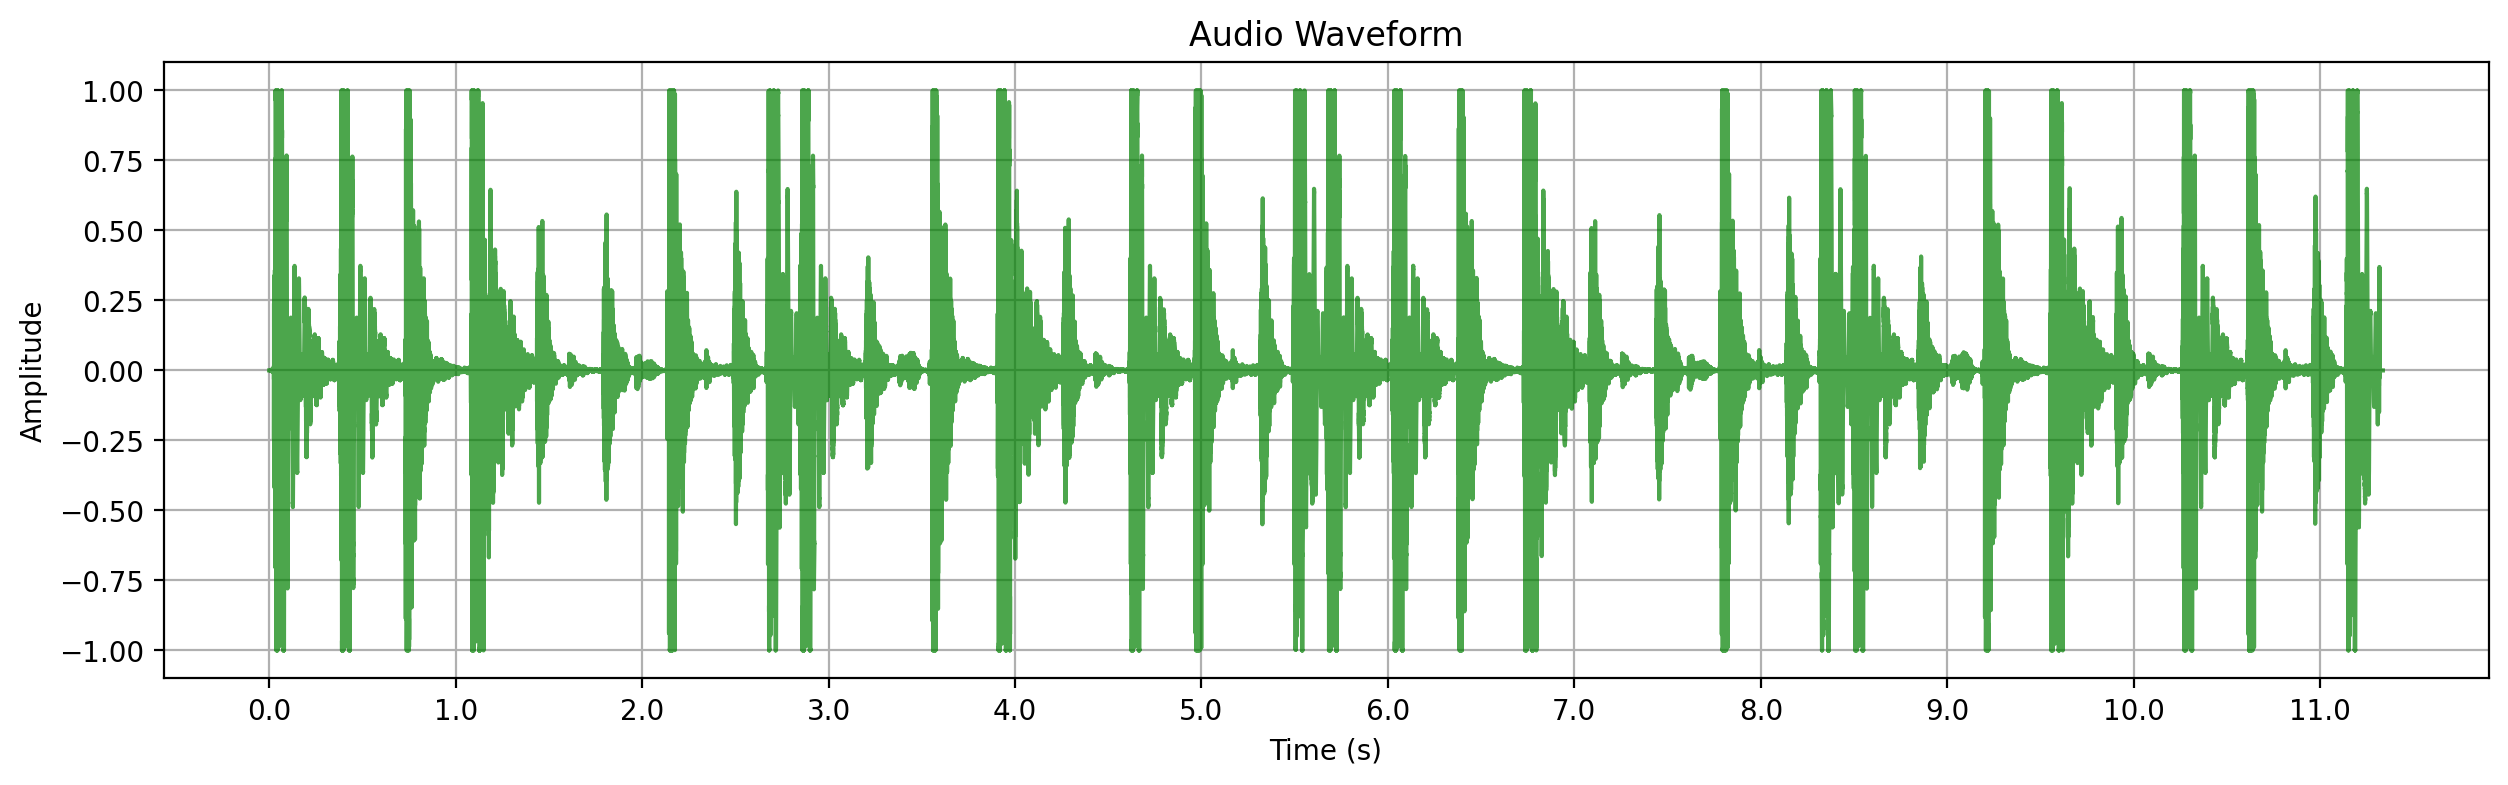

In [32]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [33]:
audio = audio[-5 * sr:]
print(audio.shape)
print(audio)
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

torch.Size([220500])
tensor([0.0166, 0.0167, 0.0170,  ..., 0.0000, 0.0000, 0.0000])
Audio length: 5.0 seconds


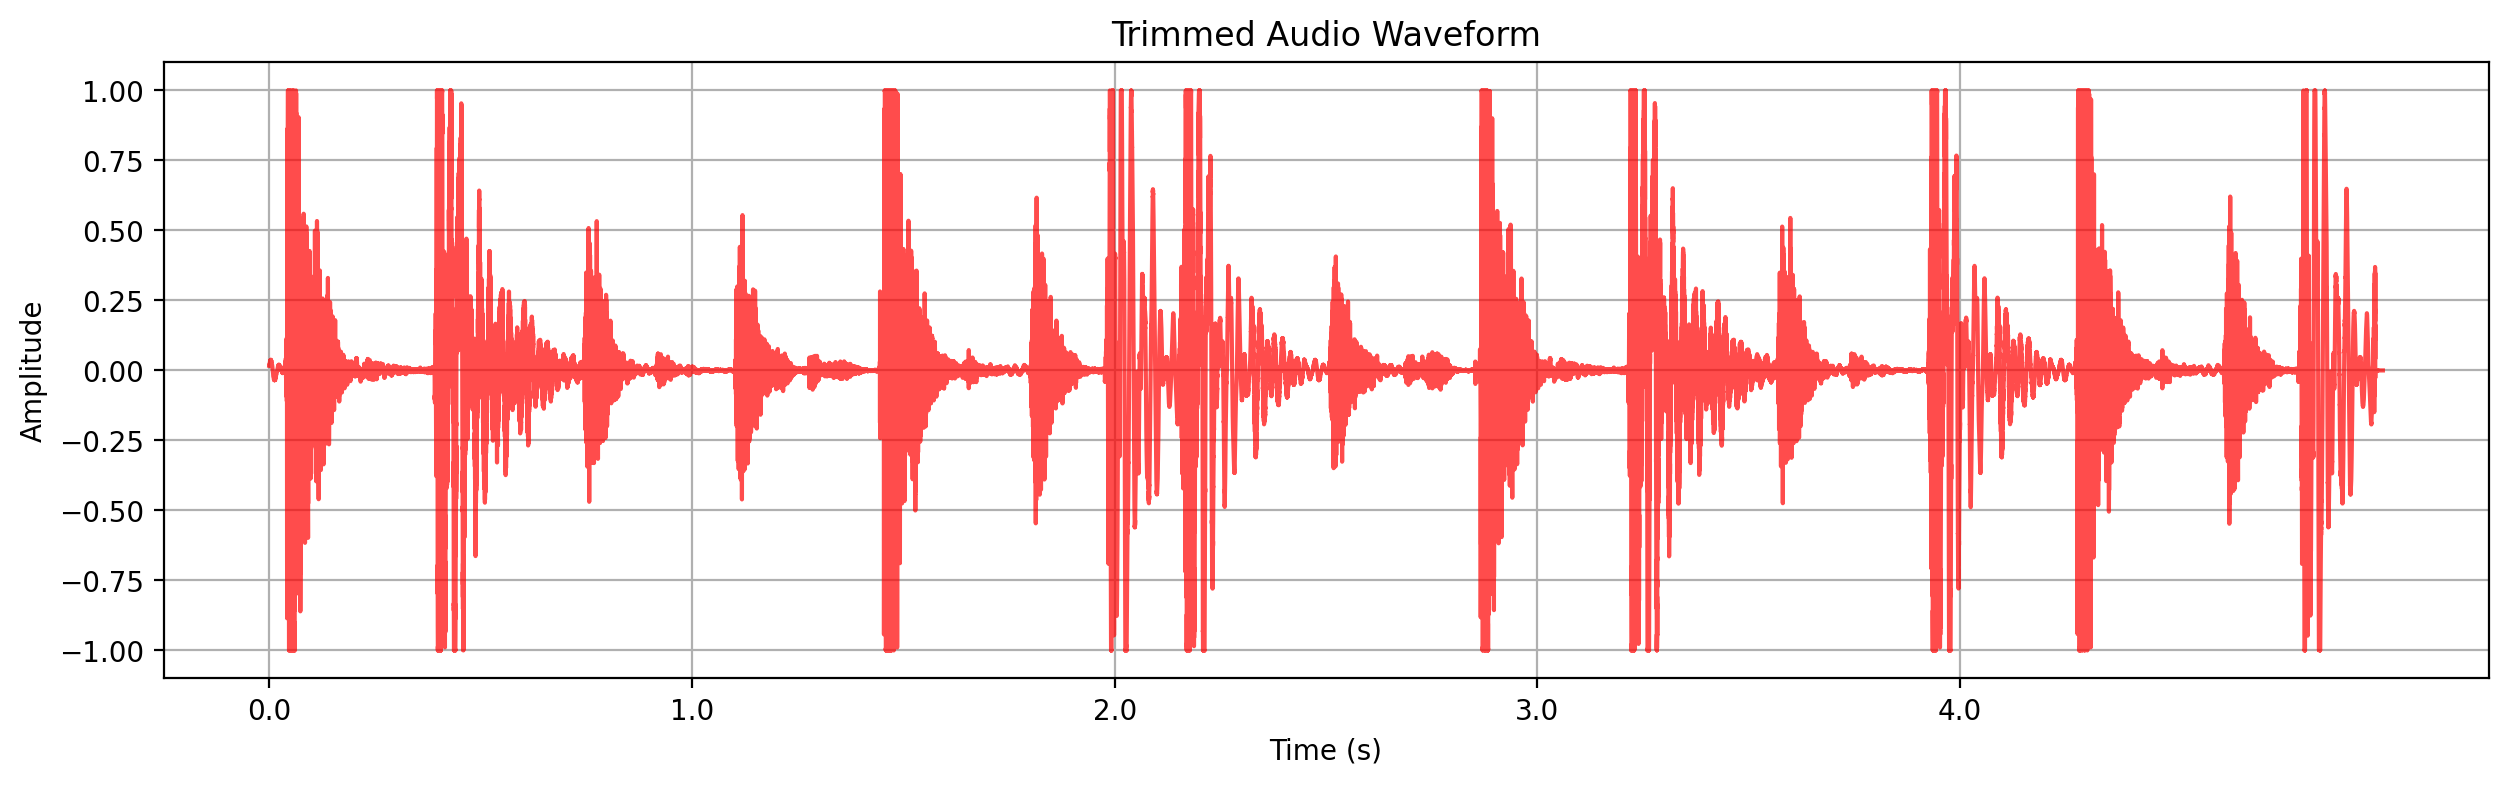

In [34]:
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

In [35]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([220500, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


In [36]:
Audio(audio, rate = sr)

In [37]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)
    

In [38]:
num_features = 10000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 10000])
tensor([[-0.0133, -0.0113,  0.0069,  ...,  0.0140, -0.0071, -0.0140],
        [-0.0129, -0.0105,  0.0068,  ...,  0.0138, -0.0093, -0.0141],
        [-0.0123, -0.0096,  0.0067,  ...,  0.0134, -0.0111, -0.0139],
        ...,
        [ 0.0136, -0.0029,  0.0009,  ...,  0.0121,  0.0140,  0.0004],
        [ 0.0133, -0.0017,  0.0008,  ...,  0.0114,  0.0135, -0.0019],
        [ 0.0129, -0.0005,  0.0008,  ...,  0.0106,  0.0124, -0.0042]])


In [39]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(220500,)


In [48]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [41]:
print(pred_audio)
print(audio)

[-0.2320203  -0.19353764 -0.12630741 ... -0.06713383 -0.07512943
 -0.09282963]
tensor([0.0166, 0.0167, 0.0170,  ..., 0.0000, 0.0000, 0.0000])


In [42]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(33.56611, 11853.692)

In [43]:
Audio(pred_audio, rate = sr)

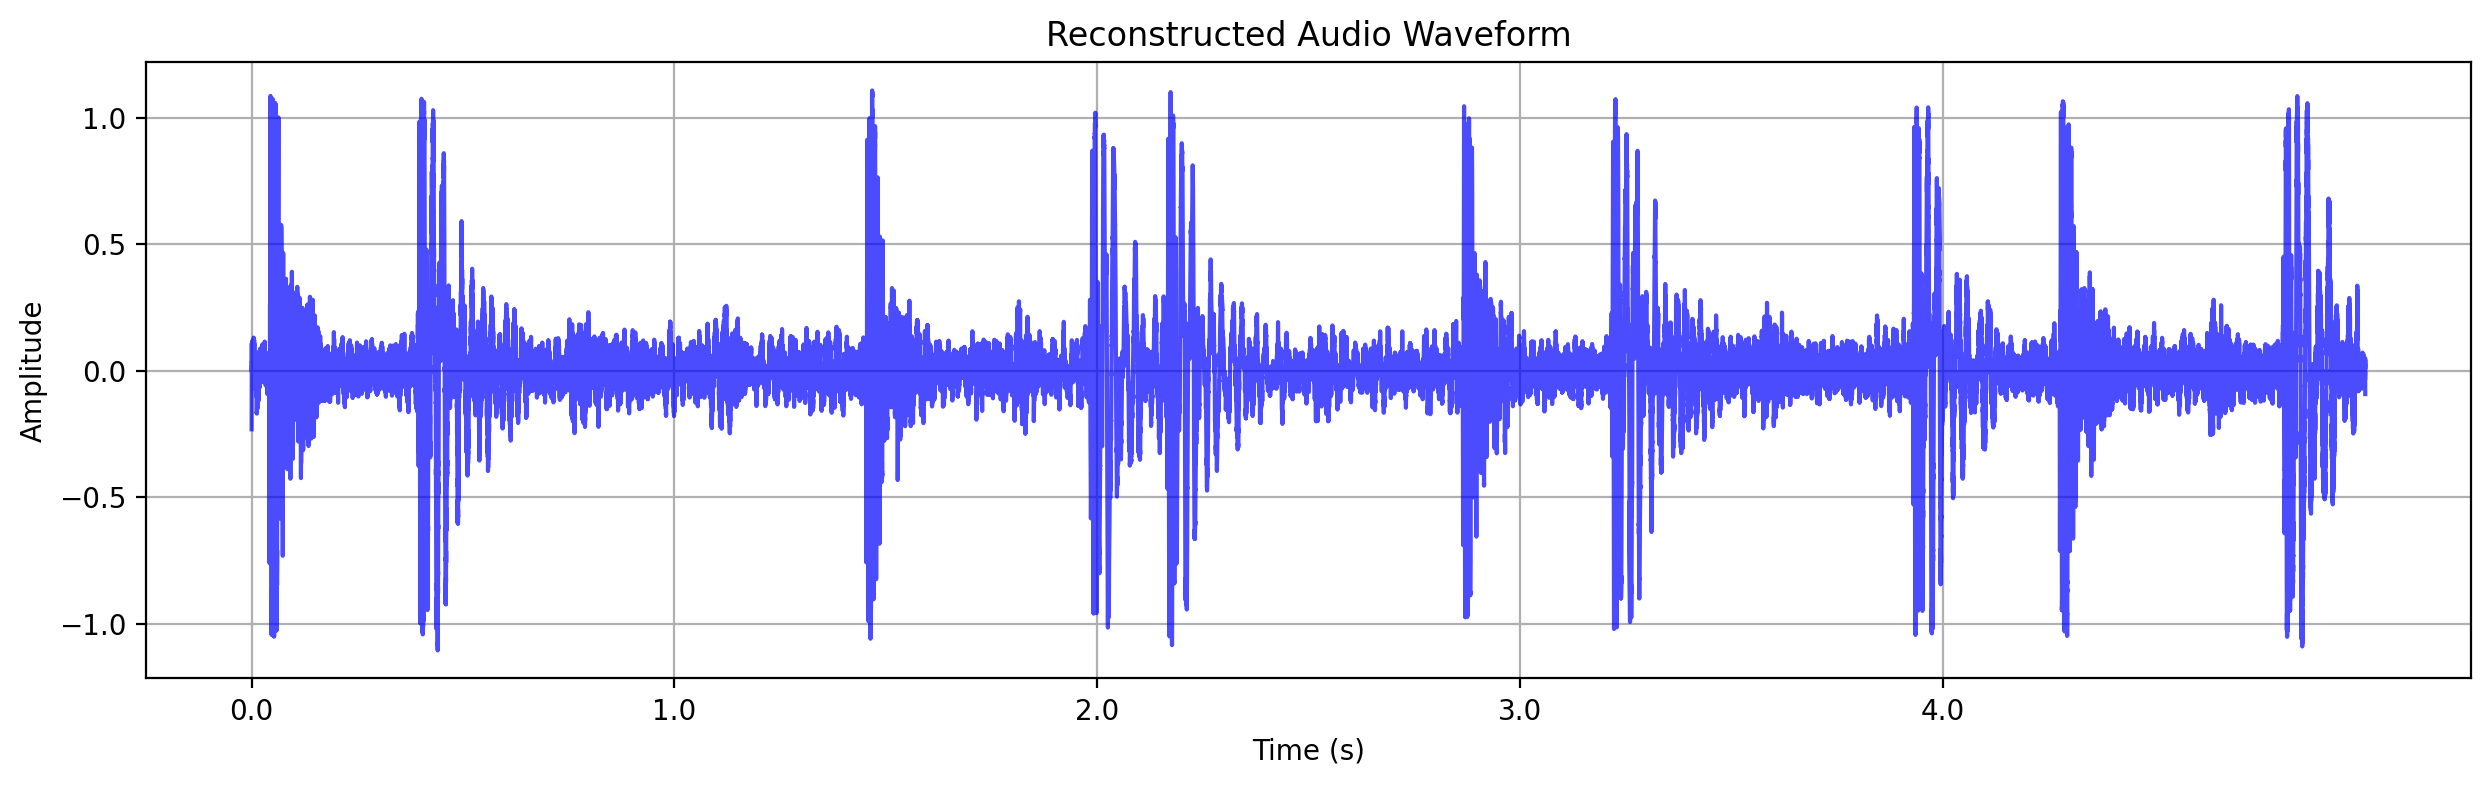

In [44]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

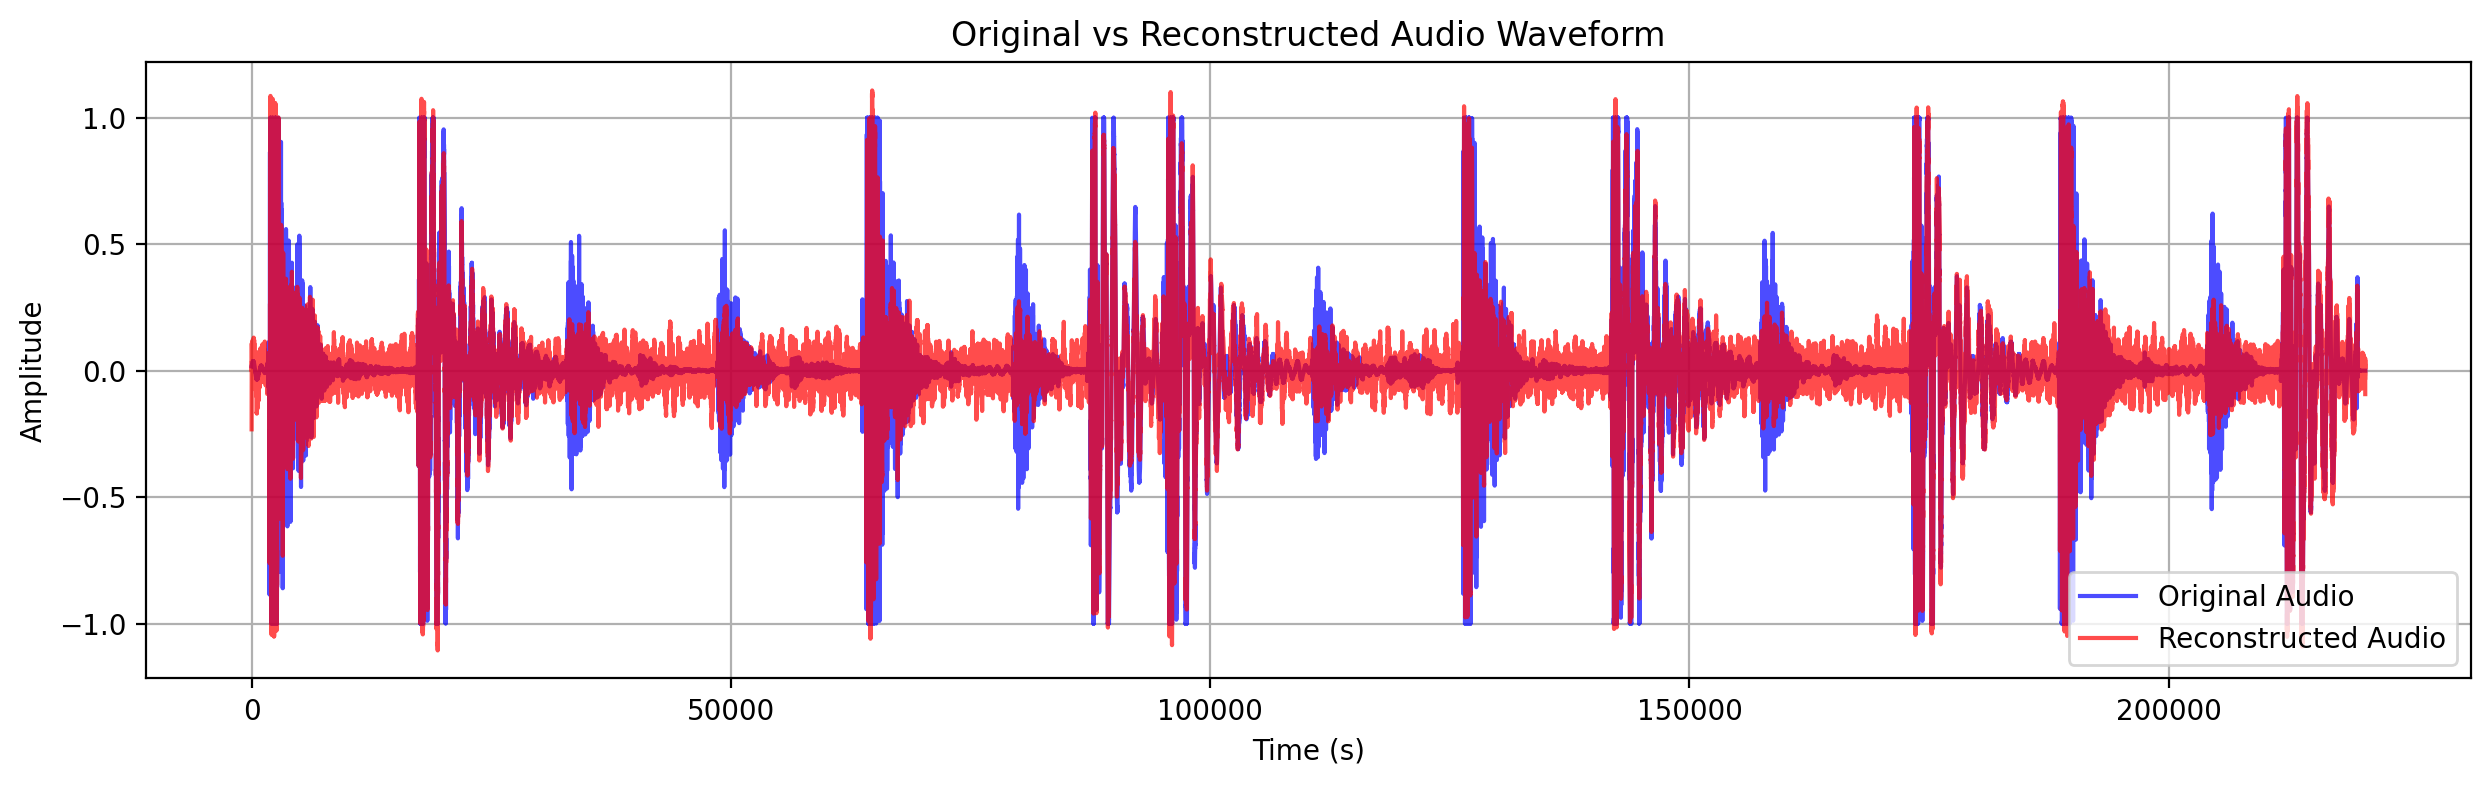

In [45]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(audio, pred_audio))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.0715


In [49]:
# Function to calculate Signal-to-Noise Ratio (SNR)
def snr(original, reconstructed):
    signal_power = np.mean(original**2)
    noise_power = np.mean((original - reconstructed)**2)
    return 10 * np.log10(signal_power / noise_power)

# Calculate SNR
snr_value = snr(audio, pred_audio)
print(f"SNR: {snr_value:.4f} dB")

TypeError: mean() received an invalid combination of arguments - got (out=NoneType, dtype=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype = None)
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)
